1. Setup

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import IsolationForest
from sklearn.mixture import GaussianMixture


In [2]:
df = pd.read_csv("../../data/raw/air_12318.csv", on_bad_lines='skip')
df['time'] = pd.to_datetime(df['time'], errors='coerce')
df = df.sort_values('time').reset_index(drop=True)


In [3]:
# ON/OFF Detection
# GMM on log(power)
p = df['ptot_W'].clip(lower=0).fillna(0)
X = np.log1p(p).values.reshape(-1,1)

gmm = GaussianMixture(n_components=2, random_state=42).fit(X)
labels = gmm.predict(X)

means = gmm.means_.flatten()
on_cluster = np.argmax(means)

df['is_running_gmm'] = (labels == on_cluster).astype(int)

In [4]:

# Cross-check with currents
df['any_current'] = df[['ia_A','ib_A','ic_A']].sum(axis=1) > 0.1

In [5]:
# Final ON/OFF label
df['is_running'] = ((df['is_running_gmm']==1) | df['any_current']).astype(int)

print("ON/OFF split:", df['is_running'].value_counts(normalize=True))


ON/OFF split: is_running
0    0.872446
1    0.127554
Name: proportion, dtype: float64


In [6]:
#Filter ON cycles
df_on = df[df['is_running'] == 1].copy()

2. Feature Engineering

In [7]:
# Current imbalance
if all(col in df_on.columns for col in ['ia_A','ib_A','ic_A']):
    df_on['current_imbalance'] = df_on[['ia_A','ib_A','ic_A']].std(axis=1)

In [8]:
# Voltage imbalance (if available)
voltage_cols = [c for c in df_on.columns if c.lower().startswith('mv')]
if len(voltage_cols) >= 3:
    df_on['voltage_imbalance'] = df_on[voltage_cols].std(axis=1)

In [9]:
# Power factor anomaly (deviation from ideal = 1)
if 'pftot_None' in df_on.columns:
    df_on['pf_anomaly'] = np.abs(1 - df_on['pftot_None'])

In [10]:
# Temperature rate of change
temp_cols = [c for c in df_on.columns if 'temp' in c.lower()]
for col in temp_cols:
    df_on[f'{col}_roc'] = df_on[col].diff()

In [11]:
# Fuel rate of change
fuel_cols = [c for c in df_on.columns if 'fuel' in c.lower()]
for col in fuel_cols:
    df_on[f'{col}_roc'] = df_on[col].diff()

In [12]:
# Rolling means & stds
rolling_window = 60  # adjust (e.g., 60 rows ~ 1h if data is per minute)
for col in ['ptot_W','ia_A','pf_anomaly']:
    if col in df_on.columns:
        df_on[f'{col}_rollmean'] = df_on[col].rolling(window=rolling_window, min_periods=1).mean()
        df_on[f'{col}_rollstd']  = df_on[col].rolling(window=rolling_window, min_periods=1).std()

In [13]:
# Ensure 'time' is in the dataframe
if 'time' not in df.columns and 'time' in locals():
    df['time'] = pd.to_datetime(df_raw['time'], errors='coerce')  # recover from raw if needed

# Reorder columns for clarity
cols = ['time'] + [c for c in df.columns if c != 'time']
df = df[cols]


In [14]:
# Define which columns are actual features
exclude_cols = ['time', 'is_running', 'iforest_anomaly', 'heuristic_anomaly']
feature_cols = [c for c in df_on.columns if c not in exclude_cols]

print("Number of features:", len(feature_cols))
print("Sample features:", feature_cols[:10])


Number of features: 56
Sample features: ['id', 'epoch', 'air', 'device', 'mVa_V', 'mVb_V', 'mVc_v', 'mVa-mBb_V', 'mVb-mVc_V', 'mVc-mVa_V']


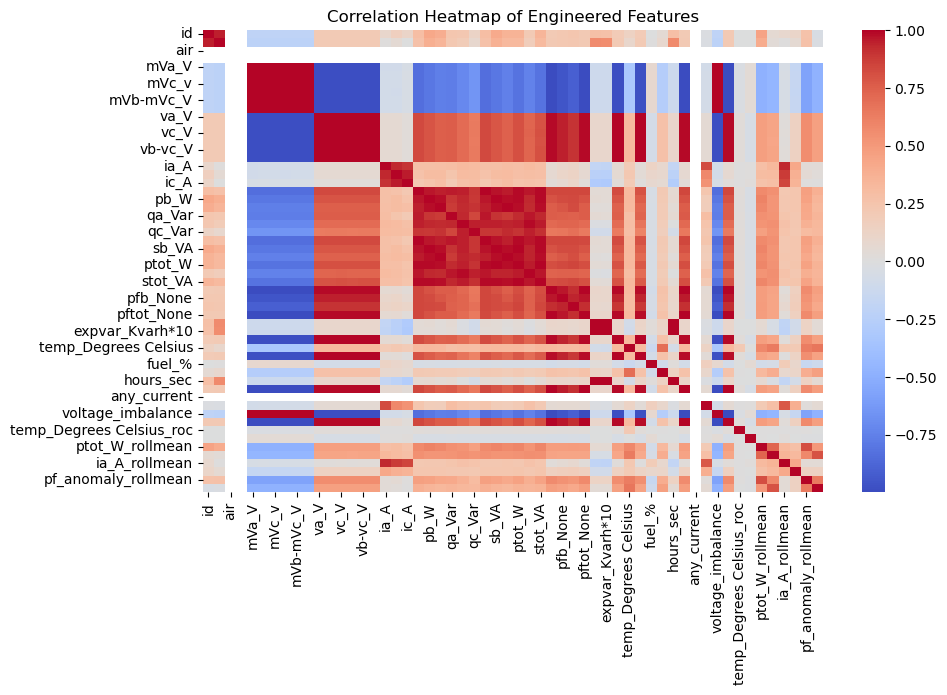

Highly correlated feature pairs (>0.95):
('mVa_V', 'mVb_V', 0.9999502516651855)
('mVa_V', 'mVc_v', 0.9999637243960561)
('mVa_V', 'mVa-mBb_V', 0.999989740932252)
('mVa_V', 'mVb-mVc_V', 0.9999674695903271)
('mVa_V', 'mVc-mVa_V', 0.9999752114586884)
('mVa_V', 'va_V', -0.9857583600219197)
('mVa_V', 'vb_V', -0.985750081425482)
('mVa_V', 'vc_V', -0.9858585061662808)
('mVa_V', 'va-vb_V', -0.9856732994004986)
('mVa_V', 'vb-vc_V', -0.9858023112246473)
('mVa_V', 'vc-va_V', -0.9858488568899764)
('mVa_V', 'pfa_None', -0.9975711866988799)
('mVa_V', 'pfb_None', -0.956226427282782)
('mVa_V', 'pftot_None', -0.997844068844684)
('mVa_V', 'freq_Hz*10', -0.9852781837638557)
('mVa_V', 'pressure_Bar', -0.982113255140251)
('mVa_V', 'is_running_gmm', -0.9985098857191358)
('mVa_V', 'voltage_imbalance', 0.999973025719557)
('mVa_V', 'pf_anomaly', -0.9978150505888729)
('mVb_V', 'mVa_V', 0.9999502516651855)
('mVb_V', 'mVc_v', 0.9999779330475747)
('mVb_V', 'mVa-mBb_V', 0.9999732210770594)
('mVb_V', 'mVb-mVc_V', 0.9

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt

# Compute correlations for engineered features only
corr = df_on[feature_cols].corr()

plt.figure(figsize=(10,6))
sns.heatmap(corr, cmap="coolwarm", center=0, cbar=True)
plt.title("Correlation Heatmap of Engineered Features")
plt.show()

# Optionally: print highly correlated pairs
threshold = 0.95
high_corr = [(i, j, corr.loc[i, j]) 
             for i in corr.columns for j in corr.columns 
             if i != j and abs(corr.loc[i, j]) > threshold]

print("Highly correlated feature pairs (>0.95):")
for pair in high_corr:
    print(pair)


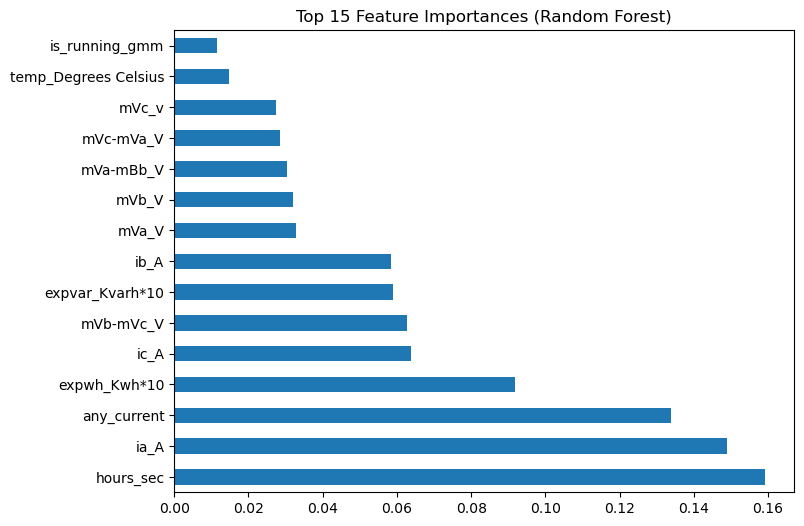

In [16]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pandas as pd

# Features (exclude id/time-like stuff)
feature_cols = [c for c in df.columns if c not in ['id','time','epoch','is_running','anomaly']]

X = df[feature_cols]
y = df['is_running']  # or your anomaly labels

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

importances = pd.Series(rf.feature_importances_, index=feature_cols)
importances.nlargest(15).plot(kind='barh', figsize=(8,6))
plt.title("Top 15 Feature Importances (Random Forest)")
plt.show()


### Feature Explanations

- **voltage_imbalance** = `std(mVa_V, mVb_V, mVc_V)`  
  High values indicate phase imbalance, which stresses the generator.

- **current_imbalance** = `std(ia_A, ib_A, ic_A)`  
  Highlights uneven load across phases, possible wiring or load issues.

- **pf_anomaly** = `|1 - pftot_None|`  
  Shows inefficiency in power usage. Large deviations = possible electrical faults.

- **temp_roc** = change in temperature over time  
  Sudden rises may indicate cooling issues or overload.

- **fuel_roc** = change in fuel level  
  Smooth drops = normal usage, sharp drops = refueling events or sensor errors.

- **rolling means / stds** (for power, current, temp, etc.)  
  Capture long-term trends instead of just single data points.

👉 These features together capture **operational health signals** and form the input for anomaly detection / predictive maintenance models.


3. Save Outputs

In [17]:
print("Columns before saving:", df.columns.tolist())
print("Shape before saving:", df.shape)


Columns before saving: ['time', 'id', 'epoch', 'air', 'device', 'mVa_V', 'mVb_V', 'mVc_v', 'mVa-mBb_V', 'mVb-mVc_V', 'mVc-mVa_V', 'va_V', 'vb_V', 'vc_V', 'va-vb_V', 'vb-vc_V', 'vc-va_V', 'ia_A', 'ib_A', 'ic_A', 'pa_W', 'pb_W', 'pc_W', 'qa_Var', 'qb_Var', 'qc_Var', 'sa_VA', 'sb_VA', 'sc_VA', 'ptot_W', 'qtot_Var', 'stot_VA', 'pfa_None', 'pfb_None', 'pfc_None', 'pftot_None', 'expwh_Kwh*10', 'expvar_Kvarh*10', 'freq_Hz*10', 'temp_Degrees Celsius', 'pressure_Bar', 'fuel_%', 'vbat_V', 'hours_sec', 'is_running_gmm', 'any_current', 'is_running']
Shape before saving: (510797, 47)


In [18]:
# --- Preserve 'time' column ---
if 'time' not in df.columns:
    # If you lost 'time', reload it from raw data
    df_raw = pd.read_csv("../../data/raw/air_12318.csv", on_bad_lines='skip')
    df_raw['time'] = pd.to_datetime(df_raw['time'], errors='coerce')
    df['time'] = df_raw.loc[df.index, 'time'].values

# Move 'time' to the front
cols = ['time'] + [c for c in df.columns if c != 'time']
df = df[cols]

print("✅ 'time' column preserved in final features:", 'time' in df.columns)


✅ 'time' column preserved in final features: True


In [19]:
import os
processed_dir = "../../data/processed"

full_path_parquet = os.path.join(processed_dir, "air_12318_features_full.parquet")
full_path_csv = os.path.join(processed_dir, "air_12318_features_full.csv")

sample_path_parquet = os.path.join(processed_dir, "air_12318_features_sample.parquet")
sample_path_csv = os.path.join(processed_dir, "air_12318_features_sample.csv")

df.to_parquet(full_path_parquet, index=False)
df.to_csv(full_path_csv, index=False)

df.head(10000).to_parquet(sample_path_parquet, index=False)
df.head(10000).to_csv(sample_path_csv, index=False)

print("✅ Saved processed features with all engineered columns.")


✅ Saved processed features with all engineered columns.
